# In vehicle coupon recommendation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#set pandas column width to display full text
pd.set_option('display.max_colwidth', 1)

# Setting up the aesthetics for the plots
sns.set(style="whitegrid")

/tmp/ipykernel_84340/2858832.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load the dataset

In [2]:
# Load the dataset
file_path = 'data/in-vehicle-coupon-recommendation-uevora.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,Work,Alone,Sunny,55,7AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,1,0,1,1
1,Work,Alone,Sunny,55,7AM,Bar,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,1,0,1,0
2,Work,Alone,Sunny,80,7AM,Restaurant(20-50),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,1,0,1
4,Work,Alone,Sunny,55,7AM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0


# Feature Analysis

- **destination**: The destination where the user is going.
- **passanger**: Information about the passengers.
- **weather**: The weather condition.
- **temperature**: The temperature at the time.
- **time**: The time when the coupon is offered.
- **coupon**: Type of coupon offered.
- **expiration**: The expiration time of the coupon.
- **gender**: The gender of the user.
- **age**: The age of the user.
- **maritalStatus**: The marital status of the user.
- **has_children**: Indicates if the user has children.
- **education**: The education level of the user.
- **occupation**: The occupation of the user.
- **income**: The income level of the user.
- **car**: Information about the car.
- **Bar**: Frequency of visiting bars.
- **CoffeeHouse**: Frequency of visiting coffee houses.
- **CarryAway**: Frequency of getting carry away food.
- **RestaurantLessThan20**: Frequency of visiting restaurants with prices less than $20.
- **Restaurant20To50**: Frequency of visiting restaurants with prices between $20 and $50.
- **toCoupon_GEQ5min**: Indicates if the coupon is at least 5 minutes away.
- **toCoupon_GEQ15min**: Indicates if the coupon is at least 15 minutes away.
- **toCoupon_GEQ25min**: Indicates if the coupon is at least 25 minutes away.
- **direction_same**: Indicates if the direction of the coupon is the same as the current direction.
- **direction_opp**: Indicates if the direction of the coupon is opposite to the current direction.
- **Y**: The target variable indicating whether the coupon was accepted or not.


In [3]:
# Performing detailed analysis of each feature
feature_analysis = pd.DataFrame()

# Adding columns for analysis
feature_analysis['Feature'] = data.columns
feature_analysis['Data Type'] = [data[feature].dtype for feature in data.columns]
feature_analysis['Unique Values'] = [data[feature].nunique() for feature in data.columns]
feature_analysis['Missing Values'] = [data[feature].isnull().sum() for feature in data.columns]
feature_analysis['Examples'] = [data[feature].dropna().unique()[:5] for feature in data.columns] # showing first 5 unique values

feature_analysis.set_index('Feature', inplace=True)
feature_analysis

,Data Type,Unique Values,Missing Values,Examples
Feature,,,,
destination,object,3,0,"[Work, No Urgent Place, Home]"
passanger,object,4,0,"[Alone, Friend(s), Kid(s), Partner]"
weather,object,3,0,"[Sunny, Rainy, Snowy]"
temperature,int64,3,0,"[55, 80, 30]"
time,object,6,0,"[7AM, 2PM, 10AM, 6PM, 10PM]"
coupon,object,5,0,"[Coffee House, Bar, Restaurant(20-50), Carry out & Take away, Restaurant(<20)]"
expiration,object,2,0,"[2h, 1d]"
gender,object,2,0,"[Female, Male]"
age,object,10,0,"[21, 41, 50plus, 31, 1]"


Observations:

- Most features are categorical (object type), with a few numerical features (int64).
- There are significant missing values in the 'car' feature and some missing values in features related to the frequency of visiting different types of establishments.
- The dataset seems to have a good mix of demographic, situational, and preference-related features.

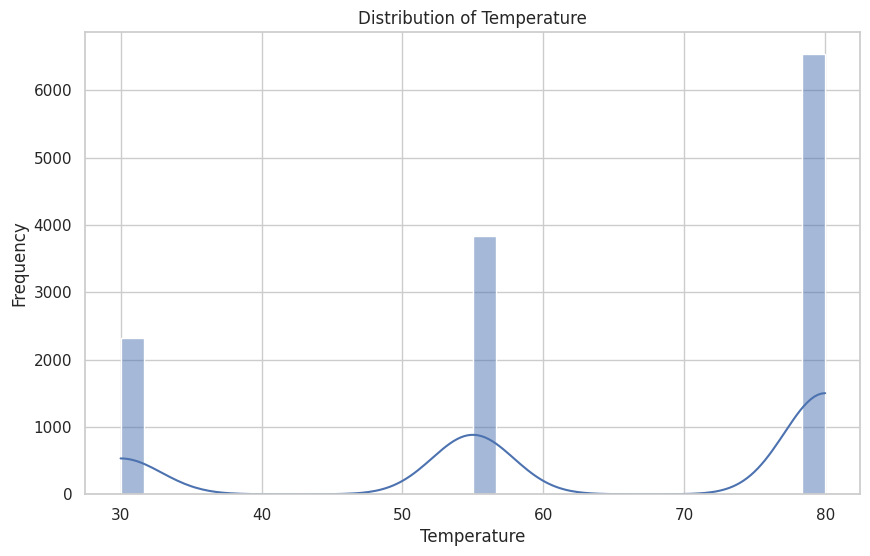

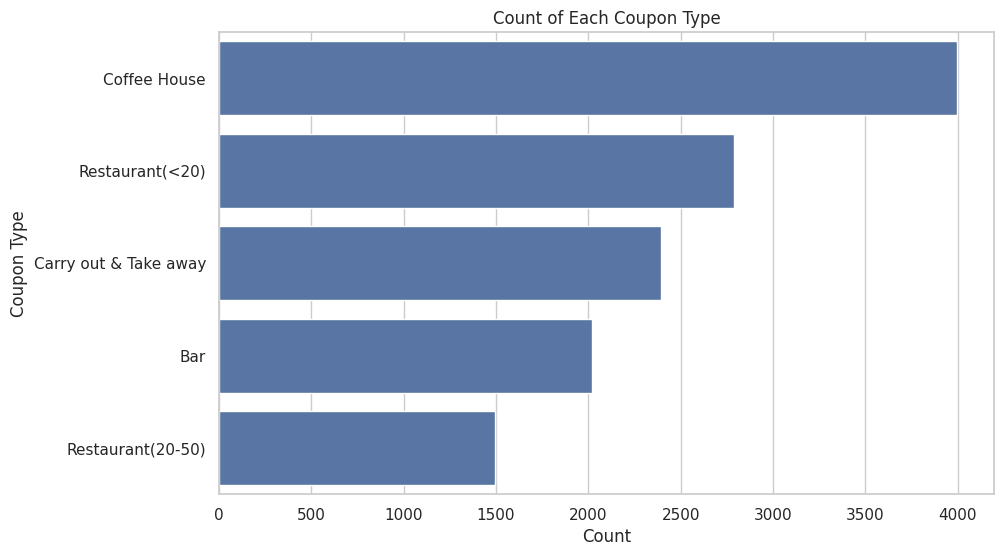

In [4]:
# Selecting a couple of different types of features for visualization
# A numerical feature: 'temperature'
# A categorical feature: 'coupon'

# Plotting the distribution of 'temperature'
plt.figure(figsize=(10, 6))
sns.histplot(data['temperature'], bins=30, kde=True)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Plotting the count of each category in 'coupon'
plt.figure(figsize=(10, 6))
sns.countplot(y='coupon', data=data, order = data['coupon'].value_counts().index)
plt.title('Count of Each Coupon Type')
plt.xlabel('Count')
plt.ylabel('Coupon Type')
plt.show()

**Distribution of Temperature**: This histogram shows the frequency distribution of the 'temperature' feature, which is numerical. The plot gives an insight into the range of temperatures and how they are distributed across the dataset.

**Count of Each Coupon Type**: This bar chart displays the count of each type of coupon, which is a categorical feature. It illustrates the frequency of each coupon type in the dataset, providing an understanding of which coupons are more common.

These visualizations help in understanding the distribution and prevalence of different features in the dataset. 

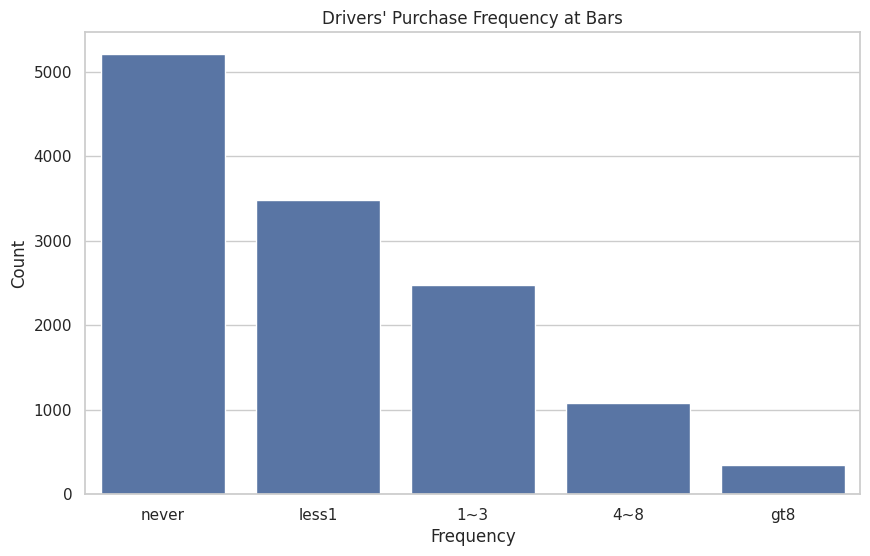

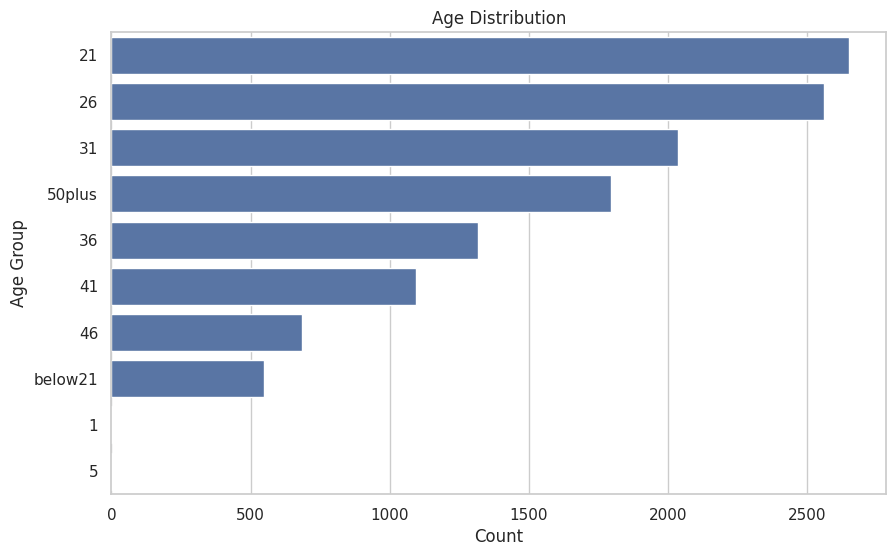

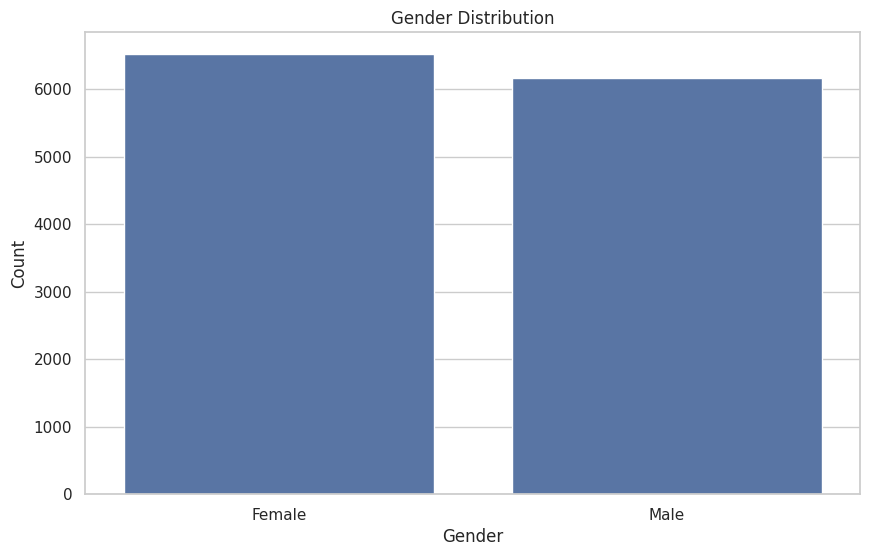

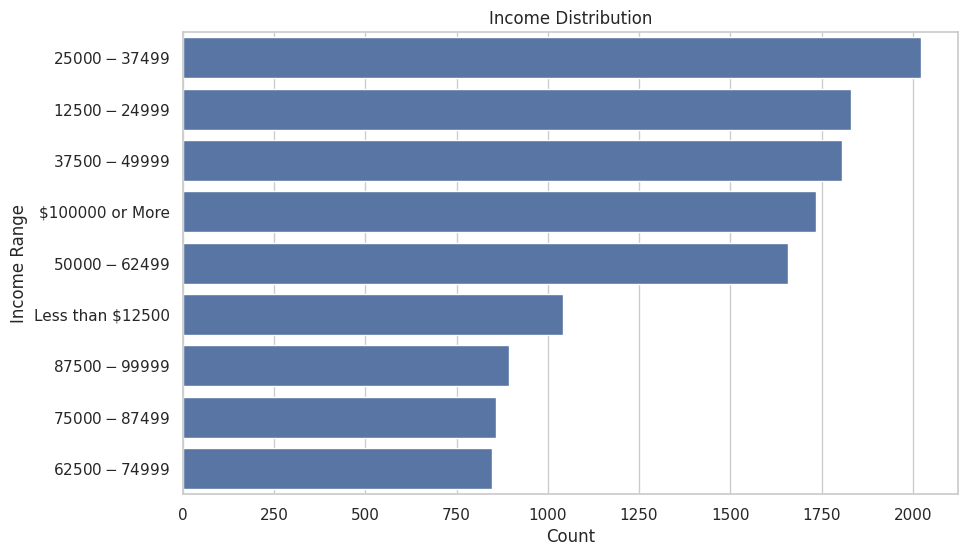

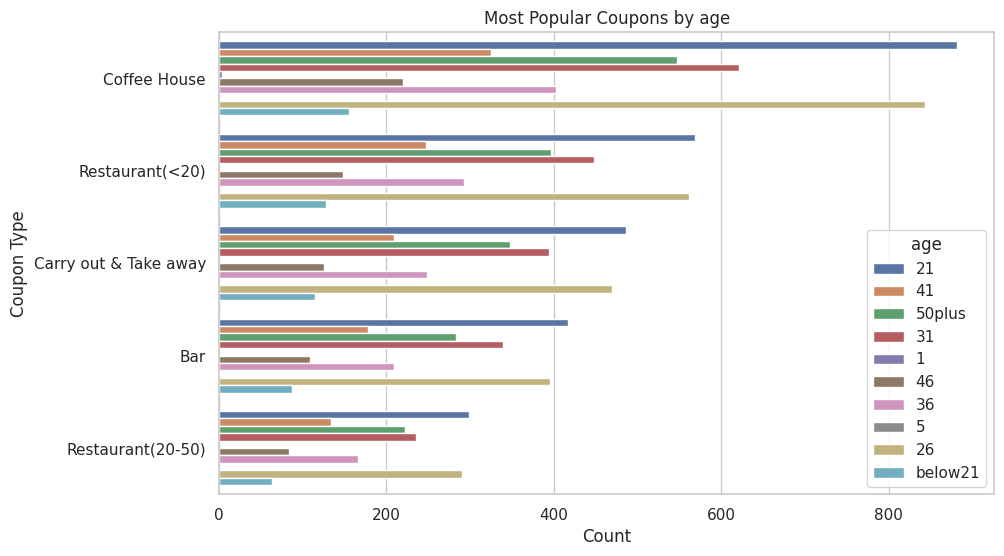

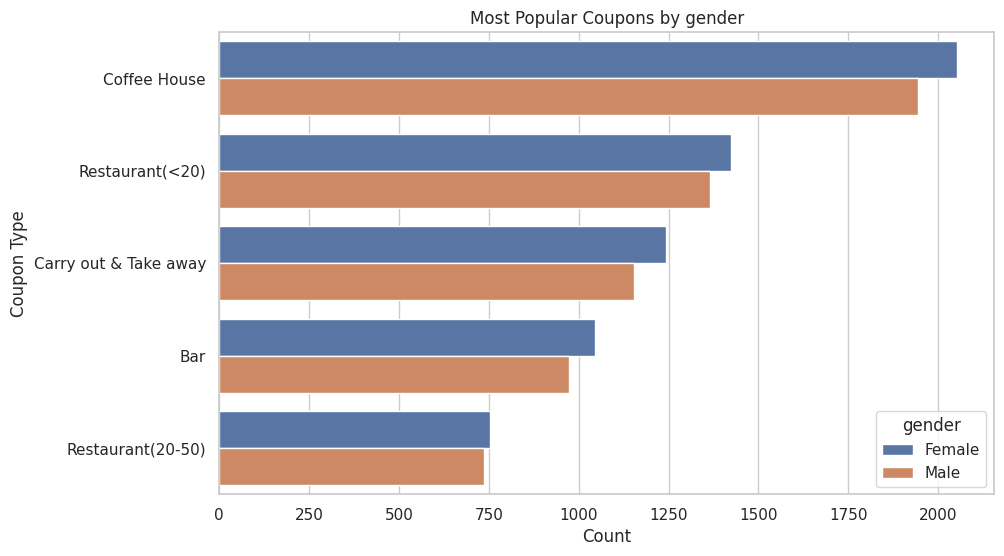

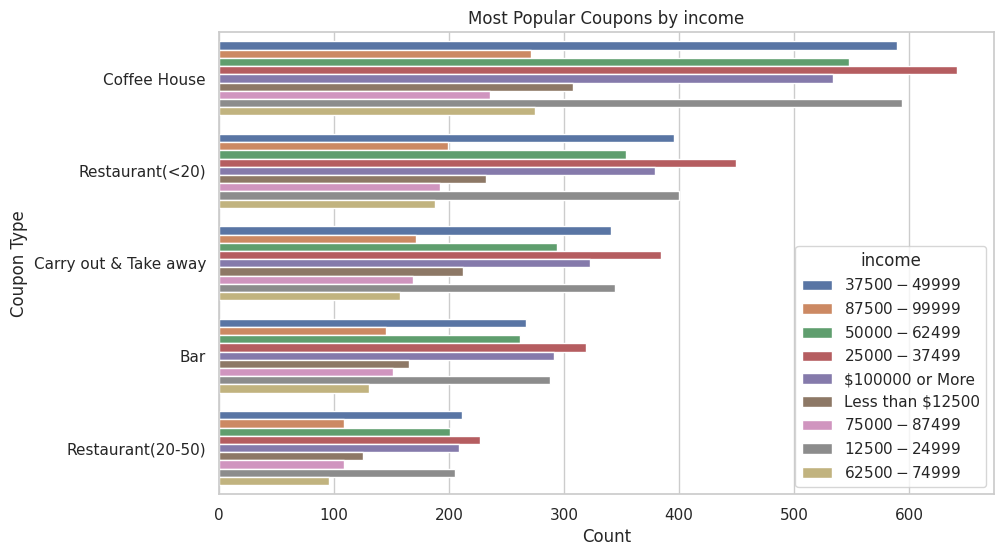

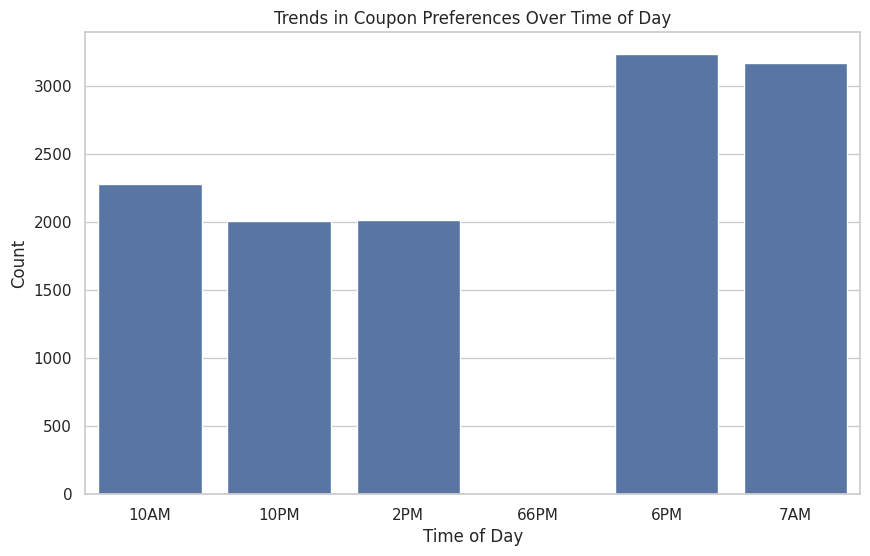

In [5]:
# 1. Drivers' purchase frequency (using 'Bar' as an example)
plt.figure(figsize=(10, 6))
sns.countplot(x='Bar', data=data, order=data['Bar'].value_counts().index)
plt.title('Drivers\' Purchase Frequency at Bars')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()

# 2. Age, Sex, and Income Distribution
# Age Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='age', data=data, order=data['age'].value_counts().index)
plt.title('Age Distribution')
plt.xlabel('Count')
plt.ylabel('Age Group')
plt.show()

# Gender Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=data, order=data['gender'].value_counts().index)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Income Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='income', data=data, order=data['income'].value_counts().index)
plt.title('Income Distribution')
plt.xlabel('Count')
plt.ylabel('Income Range')
plt.show()

# 3. Most Popular Coupons by Age Group, Gender and Income
# Function to plot popular coupons by different groups
def plot_popular_coupons_by_group(group):
    plt.figure(figsize=(10, 6))
    sns.countplot(y='coupon', data=data, hue=group, order=data['coupon'].value_counts().index)
    plt.title(f'Most Popular Coupons by {group}')
    plt.xlabel('Count')
    plt.ylabel('Coupon Type')
    plt.show()

plot_popular_coupons_by_group('age')
plot_popular_coupons_by_group('gender')
plot_popular_coupons_by_group('income')

# 4. Trends in Coupon Preferences Over Time
# Assuming 'time' represents the time of the day the coupon was offered
plt.figure(figsize=(10, 6))
sns.countplot(x='time', data=data, order=sorted(data['time'].unique()))
plt.title('Trends in Coupon Preferences Over Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count')
plt.show()


**Drivers' Purchase Frequency at Bars**: 
- This count plot shows how often drivers visit bars, categorized by their frequency (e.g., 'never', 'less1', '1~3', etc.).

**Age, Sex, and Income Distribution**:
- Age Distribution: The count plot for age groups shows the number of individuals in each age category.
- Gender Distribution: This plot illustrates the distribution of genders in the dataset.
- Income Distribution: The count plot for income ranges shows the distribution of individuals across different income levels.

**Most Popular Coupons by Age Group, Gender, and Income**:
- These plots illustrate the popularity of different types of coupons among various age groups, genders, and income levels.

**Trends in Coupon Preferences Over Time**: 
- This plot shows the trend in coupon preferences based on the time of day the coupon was offered. It helps in understanding which times of the day are more popular for different coupon types.

These visualizations offer insights into the purchasing behaviors of drivers, demographic distributions, and preferences for coupons across different demographic groups and times of day. 

In [6]:
# Analysis for duplicates, missing values, and invalid/inconsistent values

# 1. Checking for duplicates
duplicate_rows = data.duplicated().sum()

# 2. Checking for missing values
missing_values = data.isnull().sum()

# 3. Checking for inconsistent or invalid values
# For numerical features, checking for values that are outside a reasonable range
# For categorical features, checking for any values that are not in the expected set of categories

# Analyzing 'temperature' for any unreasonable values
unreasonable_temperatures = data[(data['temperature'] < -50) | (data['temperature'] > 130)].shape[0]

# Analyzing categorical features like 'gender', 'age', 'income' for any inconsistent categories
# Checking if all values are within the expected set of categories
expected_genders = ['Female', 'Male']
unexpected_gender_values = data[~data['gender'].isin(expected_genders)].shape[0]

expected_age_groups = ['21', '41', '50plus', '31', '1', '36', '26', '46', 'below21', '56']
unexpected_age_values = data[~data['age'].isin(expected_age_groups)].shape[0]

# It's challenging to define a fixed set of expected values for 'income' without domain knowledge
# However, we can check for any empty or purely numeric values which might indicate inconsistency
unexpected_income_values = data[data['income'].str.isnumeric() | data['income'].str.isspace() | (data['income'] == '')].shape[0]

# Summarizing the findings
summary = {
    "Duplicates": duplicate_rows,
    "Missing Values": missing_values.sum(),
    "Unreasonable Temperatures": unreasonable_temperatures,
    "Unexpected Gender Values": unexpected_gender_values,
    "Unexpected Age Values": unexpected_age_values,
    "Unexpected Income Values": unexpected_income_values
}

summary

{'Duplicates': 83,
 'Missing Values': 13379,
 'Unreasonable Temperatures': 0,
 'Unexpected Gender Values': 0,
 'Unexpected Age Values': 1,
 'Unexpected Income Values': 0}

**Duplicates**:

    - Found 83 duplicate rows.
    - Criteria: Rows were considered duplicates if all their feature values matched exactly with another row.

**Missing Values**:

    - A total of 13,379 missing values were found in the dataset.
    - Criteria: Any cell with a NaN or null value was counted as a missing value.

**Inconsistent or Invalid Values**:

    - Unreasonable Temperatures: No instances found.
        Criteria: Temperatures outside the range of -50 to 130 degrees were considered unreasonable, assuming the temperature is in Fahrenheit. This range is chosen based on typical earthly temperatures.
    - Unexpected Gender Values: No instances found.
        Criteria: Only 'Female' and 'Male' were considered valid. Any other value would have been counted as unexpected.
    - Unexpected Age Values: 1 instance found.
        Criteria: Valid age groups were predefined (e.g., '21', '41', '50plus', etc.). Any value outside these categories was considered unexpected.
    - Unexpected Income Values: No instances found.
        Criteria: Income values that are purely numeric, blank, or whitespace were considered invalid. This is based on the assumption that income should be represented in a specific format or range.

To summarize, the dataset contains a small number of duplicates and a significant number of missing values, but it generally does not have many unreasonable or inconsistent values. The presence of missing values, especially, might require handling such as imputation or removal, depending on the nature of the analysis or modeling you plan to perform.

In [7]:
# Function to check for unreasonable values in numerical features
def check_unreasonable_numerical(feature, lower_bound, upper_bound):
    return data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].shape[0]


# Function to check for unexpected values in categorical features
def check_unexpected_categorical(feature, expected_values):
    return data[~data[feature].isin(expected_values)].shape[0]


# Defining bounds and expected values for each feature
feature_checks = {
    "destination": {"expected_values": ["Work", "No Urgent Place", "Home"]},
    "passanger": {"expected_values": ["Alone", "Friend(s)", "Kid(s)", "Partner"]},
    "weather": {"expected_values": ["Sunny", "Rainy", "Snowy"]},
    "temperature": {"lower_bound": -50, "upper_bound": 130},  # Fahrenheit
    "time": {"expected_values": ["7AM", "10AM", "2PM", "6PM", "10PM"]},
    "coupon": {
        "expected_values": [
            "Coffee House",
            "Bar",
            "Restaurant(20-50)",
            "Carry out & Take away",
            "Restaurant(<20)",
        ]
    },
    "expiration": {"expected_values": ["2h", "1d"]},
    "gender": {"expected_values": ["Female", "Male"]},
    "age": {
        "expected_values": [
            "below21",
            "21",
            "26",
            "31",
            "36",
            "41",
            "46",
            "50plus",
            "56",
        ]
    },
    "maritalStatus": {
        "expected_values": [
            "Unmarried partner",
            "Single",
            "Married partner",
            "Divorced",
            "Widowed",
        ]
    },
    # Skipping 'has_children' as it's binary and less likely to have invalid values
    # Skipping specific checks for 'education', 'occupation', 'income', 'car' due to wide range of possible valid values
    "Bar": {"expected_values": ["never", "less1", "1~3", "4~8", "gt8"]},
    "CoffeeHouse": {"expected_values": ["never", "less1", "1~3", "4~8", "gt8"]},
    "CarryAway": {"expected_values": ["never", "less1", "1~3", "4~8", "gt8"]},
    "RestaurantLessThan20": {
        "expected_values": ["never", "less1", "1~3", "4~8", "gt8"]
    },
    "Restaurant20To50": {"expected_values": ["never", "less1", "1~3", "4~8", "gt8"]},
    # Skipping checks for 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y' as they are binary/flag features
}


# Performing the checks

invalid_values_summary = {}

for feature, checks in feature_checks.items():
    if "lower_bound" in checks and "upper_bound" in checks:
        invalid_values_summary[feature] = check_unreasonable_numerical(
            feature, checks["lower_bound"], checks["upper_bound"]
        )

    elif "expected_values" in checks:
        invalid_values_summary[feature] = check_unexpected_categorical(
            feature, checks["expected_values"]
        )


invalid_values_summary

{'destination': 0,
 'passanger': 0,
 'weather': 0,
 'temperature': 0,
 'time': 1,
 'coupon': 0,
 'expiration': 0,
 'gender': 0,
 'age': 4,
 'maritalStatus': 0,
 'Bar': 107,
 'CoffeeHouse': 217,
 'CarryAway': 151,
 'RestaurantLessThan20': 130,
 'Restaurant20To50': 189}

- **destination**: 0 invalid values.
- **passanger**: 0 invalid values.
- **weather**: 0 invalid values.
- **temperature**: 0 invalid values.
- **time**: 1 invalid value.
- **coupon**: 0 invalid values.
- **expiration**: 0 invalid values.
- **gender**: 0 invalid values.
- **age**: 4 invalid values.
- **maritalStatus**: 0 invalid values.
- **Bar**: 107 invalid values.
- **CoffeeHouse**: 217 invalid values.
- **CarryAway**: 151 invalid values.
- **RestaurantLessThan20**: 130 invalid values.
- **Restaurant20To50**: 189 invalid values.

The criteria for determining invalid values were based on:

- For numerical features (like temperature), checking for values outside a reasonable range (e.g., -50 to 130 degrees Fahrenheit for temperature).
- For categorical features (like destination, gender, age), checking for values that are not within the expected set of categories.

This analysis reveals that most features do not contain invalid values. However, there are a significant number of invalid values in features related to visiting frequency (like Bar, CoffeeHouse, CarryAway, etc.), possibly due to data entry errors or missing categories. Additionally, a few invalid values are present in the age and time features.

Handling these invalid values would depend on the context and requirements of your analysis or modeling. 

Options include imputing with reasonable values, removing the affected rows, or re-categorizing the values

# Preparing the data for modeling

Given that the dataset will be used for creating a predictive model, it's crucial to handle issues like duplicates, missing values, and invalid entries in a way that improves the model's performance and reliability. Here's a proposed action plan for each identified situation:

**Duplicates**:
    
    - Action: Remove duplicates.
    - Justification: Duplicates can bias the model by overrepresenting certain data points.

**Missing Values**:

    - Action: For features with a significant number of missing values (like 'car'), consider dropping the feature if it's not crucial for prediction. For features with fewer missing values (like 'Bar', 'CoffeeHouse', etc.), consider imputation.
    - Justification: Dropping features with excessive missing data can simplify the model without substantial loss of information. Imputation (using methods like mean, median, or mode for numerical features, and the most frequent category for categorical features) maintains data integrity and allows the model to learn from these instances.

**Invalid Values in 'age' and 'time'**:

    - Action: Investigate the nature of these invalid values. If they are typos or minor errors, correct them. If not, consider removing these rows or imputing them.
    - Justification: Invalid values can mislead the model. Correcting them ensures accurate representation of data. Removal or imputation is a fallback if correction is not feasible.

**Invalid Values in Frequency Features ('Bar', 'CoffeeHouse', etc.)**:

    - Action: Impute these values with the most frequent category or a separate 'unknown' category.
    - Justification: Imputation preserves the data points for model training. Using the most frequent category can be a reasonable assumption for human behavior patterns. Alternatively, an 'unknown' category acknowledges the missing information without biasing the data towards a specific category.

**Handling Categorical Data**:

    - Action: Convert categorical features into a format suitable for modeling, such as one-hot encoding.
    - Justification: Most machine learning models require numerical input. One-hot encoding transforms categorical data into a binary matrix, making it easier for models to process.

**Normalization/Standardization of Numerical Data**:

    - Action: Apply normalization or standardization to numerical features, especially if using algorithms sensitive to feature scaling (like SVMs, k-NN, neural networks).
    - Justification: This enhances model performance by treating all features equally, especially in distance-based algorithms.

**Feature Engineering**:

    - Action: Consider creating new features that might be relevant for prediction, like combining related categories or deriving new categories from existing ones.
    - Justification: New features can sometimes capture relationships and patterns more effectively than original features.

Each of these actions aims to clean and prepare the data for effective modeling. The choice of specific imputation methods, encoding techniques, and feature engineering should be guided by exploratory data analysis and domain knowledge. Additionally, it's important to keep track of the transformations applied to the training data, as the same transformations will need to be applied to new data during the model's deployment phase.

# Feature Engineering and Selection

Reducing the number of attributes by half in a predictive model is a common practice to avoid overfitting, enhance interpretability, and reduce computation time. This process is known as feature selection or dimensionality reduction. There are several methods to achieve this, and the choice often depends on the nature of the data and the specific requirements of the task. 

Here's a proposed plan:

- **Correlation Analysis**: Examine the correlation between features and the target variable. High correlation with the target suggests importance for prediction.

- **Feature Importance from Model**: Use a model like Random Forest or Gradient Boosting to assess feature importance.

- **Univariate Feature Selection**: Select features based on univariate statistical tests like chi-squared, ANOVA, etc.

## Correlation Analysis and Feature Importance

Let's start with Correlation Analysis and Feature Importance using a Random Forest Classifier to identify which features might be more important for prediction. For this, we need to pre-process the data by handling missing values, encoding categorical variables, and normalizing numerical variables. Then, we'll proceed with the analysis.

In [8]:
# Data Preprocessing

# Handling missing values - Filling missing values with the mode for categorical features
for column in data.select_dtypes(include=['object']):
    data[column].fillna(data[column].mode()[0], inplace=True)

# Encoding categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Check if there are any missing values left
data.isnull().sum().sum()

/tmp/ipykernel_84340/1431715484.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)


0

In [9]:
# Splitting the dataset into features and target variable
X = data.drop('Y', axis=1)
y = data['Y']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Importance using Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Getting feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Displaying the feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances.head(13)  # Displaying half of the features

,Feature,Importance
5,coupon,0.110511
12,occupation,0.087506
13,income,0.075559
8,age,0.064732
16,CoffeeHouse,0.062836
4,time,0.055702
15,Bar,0.053499
11,education,0.050094
17,CarryAway,0.047641
18,RestaurantLessThan20,0.045230


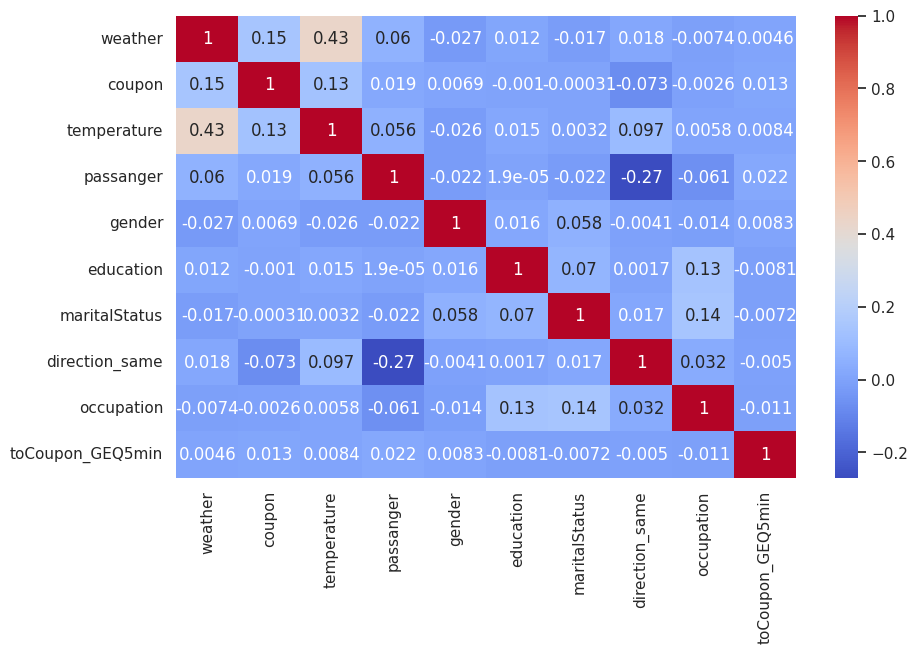

In [10]:
## Correlation Analysis
# Correlation Matrix
corr = data.corr()

# Selecting the top 10 features based on correlation
top_10_features = corr['Y'].sort_values(ascending=False).head(11).index.tolist()
top_10_features.remove('Y')

# Plotting the top 10 features based on correlation
plt.figure(figsize=(10, 6))
sns.heatmap(data[top_10_features].corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Univariate Feature Selection
selector = SelectKBest(f_classif, k=X.shape[1] // 2)
X_new = selector.fit_transform(X, y)

# Get the selected features
selected_features = X.columns[selector.get_support(indices=True)]
selected_features

Index(['passanger', 'weather', 'temperature', 'time', 'coupon', 'expiration',
       'Bar', 'CoffeeHouse', 'CarryAway', 'Restaurant20To50',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min'],
      dtype='object')

In [12]:
# Compare: feature_importances vs. selected_features vs, top_10_features

rf_feature_importances = feature_importances['Feature'].tolist()
corr_analysis = top_10_features
univariate_feature_selection = selected_features.tolist()

rf_feature_importances.sort()
corr_analysis.sort()
univariate_feature_selection.sort()


print("RandomForestClassifier       - Feature Importances:  ", rf_feature_importances)
print("Univariate Feature Selection - Selected Features:    ", univariate_feature_selection)
print("Correlation Analysis         - Top 10 Features:  ", corr_analysis)

RandomForestClassifier       - Feature Importances:   ['Bar', 'CarryAway', 'CoffeeHouse', 'Restaurant20To50', 'RestaurantLessThan20', 'age', 'car', 'coupon', 'destination', 'direction_opp', 'direction_same', 'education', 'expiration', 'gender', 'has_children', 'income', 'maritalStatus', 'occupation', 'passanger', 'temperature', 'time', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'toCoupon_GEQ5min', 'weather']
Univariate Feature Selection - Selected Features:     ['Bar', 'CarryAway', 'CoffeeHouse', 'Restaurant20To50', 'coupon', 'expiration', 'passanger', 'temperature', 'time', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'weather']
Correlation Analysis         - Top 10 Features:   ['coupon', 'direction_same', 'education', 'gender', 'maritalStatus', 'occupation', 'passanger', 'temperature', 'toCoupon_GEQ5min', 'weather']


In [13]:
# Get the intersection of all three lists
selected_features = list(set(rf_feature_importances) & set(univariate_feature_selection) & set(corr_analysis))
selected_features

['weather', 'coupon', 'passanger', 'temperature']

In [14]:
# Get the inyersection of two lists
selected_features_2 = list(set(rf_feature_importances) & set(univariate_feature_selection))
selected_features_2

['weather',
 'Bar',
 'toCoupon_GEQ15min',
 'Restaurant20To50',
 'time',
 'CoffeeHouse',
 'passanger',
 'CarryAway',
 'expiration',
 'coupon',
 'toCoupon_GEQ25min',
 'temperature']

In [15]:
# List of columns to keep
selected_features_2.append('Y')
columns_to_keep = selected_features_2

# Removing other columns from the dataset
reduced_data = data[columns_to_keep]

reduced_data.head()

,weather,Bar,toCoupon_GEQ15min,Restaurant20To50,time,CoffeeHouse,passanger,CarryAway,expiration,coupon,toCoupon_GEQ25min,temperature,Y
0,2,4,1,0,5,4,0,0,1,2,1,55,1
1,2,4,1,0,5,4,0,0,0,0,1,55,0
2,2,4,1,0,5,4,0,0,0,3,0,80,1
3,2,4,0,0,5,4,0,0,1,1,0,80,1
4,2,4,0,0,5,4,0,0,0,4,0,55,0


In [16]:
# Drop duplicates
print(reduced_data.shape)
reduced_data = reduced_data.drop_duplicates()
print(reduced_data.shape)

(12693, 13)
(10279, 13)


In [17]:
# Get distinct values for temperature
print(reduced_data["temperature"].unique())

# Since temperature has only 3 distinct values, we can encode it using LabelEncoder

le = LabelEncoder()
reduced_data['temperature'] = le.fit_transform(reduced_data['temperature'])
reduced_data["temperature"]

[55 80 30]


0        1
1        1
2        2
3        2
4        1
        ..
12653    2
12656    2
12657    2
12681    2
12683    1
Name: temperature, Length: 10279, dtype: int64

# Creating the model

In [18]:
# Splitting the data into training (75%) and test (25%) sets
X_train, X_test = train_test_split(reduced_data, test_size=0.25, random_state=42)

# Save the training and test sets to CSV files
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)

In [19]:
# Preparing the train/test split for modeling
y_train = X_train['Y']
X_train = X_train.drop('Y', axis=1)

y_test = X_test['Y']
X_test = X_test.drop('Y', axis=1)

In [20]:
# Initialize the KNN Classifier with K=3
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

Accuracy: 0.6050583657587548

Confusion Matrix:
 [[604 515]
 [500 951]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.54      0.54      1119
           1       0.65      0.66      0.65      1451

    accuracy                           0.61      2570
   macro avg       0.60      0.60      0.60      2570
weighted avg       0.60      0.61      0.60      2570



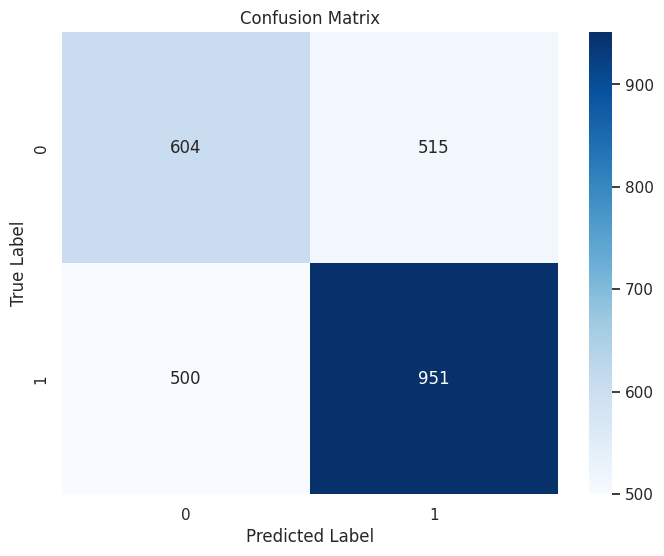

In [21]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the performance metrics
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

# Visualization of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()